# m.5.Assignment -> Spooky authorship identification via Apache Spark


| **Overview** | Use Apache Spark and machine learning to determine sentence authorship labels. |
|----------|--------------------------------------------------------------------------------|
| **Data** | [Dark, ominous, and introspective](https://www.kaggle.com/competitions/spooky-author-identification/code) |

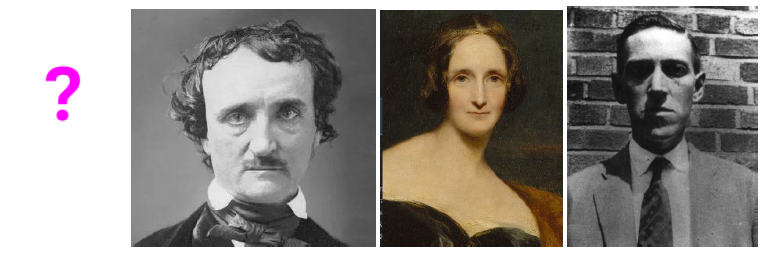

## **DETAILS**
#### **Dataset Description:** 
The spooky author identification dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer resulting in an odd non-sentence here and there. Your objective is to accurately identify the author of the sentences in the test set.
- **id** - unique identifier for each sentence
- **text** - sentence written by one of the authors
- **author** - {EAP:Edgar Allan Poe}, {HPL:HP Lovecraft}; {MWS:Mary Wollstonecraft Shelley}
#### **Objective:**
- A. Accurately identify the author of the sentences in the test set.
- B. Perform ALL work using Apache Spark.
#### **Dataset:**
- Training consists of passages with an author label.
- Test has sentences with no author labels.
#### **Competition Evaluation:**
The submissions were evaluated based on multi-class logarithmic loss. The logarithmic loss assesses the uncertainty of the predicted probabilities, penalizing confident incorrect predictions. Lower log loss values indicated better performance. 
#### **Approach:**
NLP techniques + machine learning algorithms. Feature engineering like bag-of-words, TF-IDF, word embeddings/Word2Vec. Perform algorithmic work with logistic regression, support vector machines, neural networks, and as appropriate.

## **TASKS**


### **Stage 0: Import Data**

1. Create a code notebook called: code_6_of_10_data_mine_<your_name>.ipynb
2. Load data into Spark data objects and explore structure, size, and distribution of information.


#### **Load data into Spark DataFrame**

In [1]:
# The notebook already created.
# Load data into Spark data objects and explore structure, size and distribution of information
from pyspark.sql import SparkSession
import sys
import os, sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable


# Create a SparkSession
spark = SparkSession.builder \
                    .appName("SpookyAuthor") \
                    .master("local[*]") \
                    .config("spark.pyspark.python", sys.executable) \
                    .config("spark.pyspark.driver.python", sys.executable) \
                    .config("spark.python.worker.faulthandler.enabled", "true") \
                    .config("spark.sql.execution.pyspark.udf.faulthandler.enabled", "true") \
                    .config("spark.driver.allowMultipleContexts", "true") \
                    .config("spark.executor.allowMultipleContexts", "true") \
                    .config("spark.python.worker.reuse", "true") \
                    .getOrCreate()

# Load the train.csv & test.csv dataset into a Spark DataFrame
train_df = spark.read.option("quote", "\"").option("escape", "\"").csv("data/train.csv", header=True, inferSchema=True)
test_df = spark.read.csv("data/test.csv", header=True, inferSchema=True)

# Show the first few rows of the train and test DataFrame
print("Train DataFrame:\n")
train_df.show(3)

print("\nTest DataFrame:\n")
test_df.show(3)


Train DataFrame:

+-------+--------------------+------+
|     id|                text|author|
+-------+--------------------+------+
|id26305|This process, how...|   EAP|
|id17569|It never once occ...|   HPL|
|id11008|In his left hand ...|   EAP|
+-------+--------------------+------+
only showing top 3 rows

Test DataFrame:

+-------+--------------------+
|     id|                text|
+-------+--------------------+
|id02310|Still, as I urged...|
|id24541|If a fire wanted ...|
|id00134|And when they had...|
+-------+--------------------+
only showing top 3 rows


#### **Explore structure, size, and distribution of information**

In [2]:
# Structure of the train and test DataFrame
print("Train DataFrame Structure:\n")
train_df.printSchema()

print("\nTest DataFrame Structure:\n")
test_df.printSchema()

# Size of the train and test DataFrame
print(f"\nTrain DataFrame Size: {train_df.count()}")
print(f"\nTest DataFrame Size: {test_df.count()}")

# Distribution of the train and test DataFrame
print("\nTrain DataFrame Distribution:\n")
train_df.describe().show()

print("\nTest DataFrame Distribution:\n")
test_df.describe().show()

Train DataFrame Structure:

root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)


Test DataFrame Structure:

root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)


Train DataFrame Size: 19579

Test DataFrame Size: 8392

Train DataFrame Distribution:

+-------+-------+--------------------+------+
|summary|     id|                text|author|
+-------+-------+--------------------+------+
|  count|  19579|               19579| 19579|
|   mean|   NULL|                NULL|  NULL|
| stddev|   NULL|                NULL|  NULL|
|    min|id00001|" Odenheimer, res...|   EAP|
|    max|id27971|you could not hop...|   MWS|
+-------+-------+--------------------+------+


Test DataFrame Distribution:

+-------+-------+--------------------+
|summary|     id|                text|
+-------+-------+--------------------+
|  count|   8392|                8392|
|   mean|   NULL|                NULL|
| stddev|   NULL|        

### **Stage 1: Data Preparation - Exploratory data analysis and text mining pre-processing**

3. Perform exploratory data analysis and create visualizations and tables as needed.
4. Text Preprocessing: perform tasks like tokenization and stopwords removal to clean text data.
    - Tokenize - split the text into individual words aka tokens.
    - Remove stop.words - frequently used pronouns and personal references.
      - Top ten include: I, you, he, she, it, we, they, me, him, her
    - Lemmatization - convert words to their root (optional).
      - Lemmatization is a text normalization technique that reduces words to their base or dictionary form (lemma). Use to reduce inflected or derived words to their root form for better analysis and modeling outcomes.

#### **Exploratory Data Analysis**

##### Check the null value in train dataset

In [3]:
from pyspark.sql.functions import when, col, count

# Check the null value in train dataset.
print(f"Null/Empty Value in train_df:")
train_df.select(
    [
      count(
        when(col(c).isNull(), c)
      ).alias(c) 
      for c in train_df.columns
    ]
).show()

test_df.select(
    [
      count(
        when(col(c).isNull(), c)
      ).alias(c) 
      for c in test_df.columns
    ]
).show()

Null/Empty Value in train_df:
+---+----+------+
| id|text|author|
+---+----+------+
|  0|   0|     0|
+---+----+------+

+---+----+
| id|text|
+---+----+
|  0|   0|
+---+----+



##### Show text length statistics

In [4]:
# Show text length statistics
print("\nText Length Statistics:")
train_df.select("text").summary().show()


Text Length Statistics:
+-------+--------------------+
|summary|                text|
+-------+--------------------+
|  count|               19579|
|   mean|                NULL|
| stddev|                NULL|
|    min|" Odenheimer, res...|
|    25%|                NULL|
|    50%|                NULL|
|    75%|                NULL|
|    max|you could not hop...|
+-------+--------------------+



##### Show counts of each author

Author Counts:
+------+-----+
|author|count|
+------+-----+
|   MWS| 6044|
|   HPL| 5635|
|   EAP| 7900|
+------+-----+



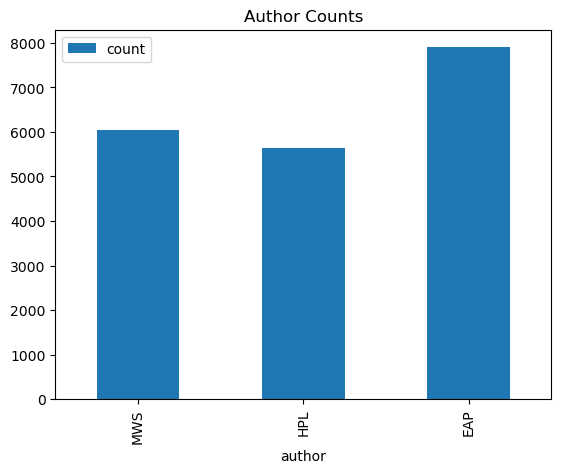

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Show counts of each author
print("Author Counts:")
author_counts_df = train_df.select("author").groupBy("author").count()
author_counts_df.show()
author_counts_df.toPandas().plot(kind='bar', x='author', y='count', title='Author Counts')
plt.show()

#### **Text Preprocessing**

Perform tasks like tokenization and stopwords removal to clean text data.

  - Tokenize - split the text into individual words aka tokens.
  - Remove stop.words - frequently used pronouns and personal references.
    - Top ten include: I, you, he, she, it, we, they, me, him, her
    - *There are couple of ways to remove stop words from the text data. One way is to use the `StopWordsRemover` class from the `pyspark.ml.feature` module.*
  - Lemmatization - convert words to their root (optional).
    - Lemmatization is a text normalization technique that reduces words to their base or dictionary form (lemma). Use to reduce inflected or derived words to their root form for better analysis and modeling outcomes.
    - *We have multiple ways to lemmatize the text data. One way is to use the `WordNetLemmatizer` class from the `nltk` library. Lemmatization is very helpful as it helps to reduce words to their base forms, allowing for more accurate analysis and identification of common word forms.*

In [6]:
import sys
print("Driver Python:", sys.executable, sys.version)
conf = spark.sparkContext.getConf()
print("spark.pyspark.python:", conf.get("spark.pyspark.python"))
print("spark.pyspark.driver.python:", conf.get("spark.pyspark.driver.python"))


Driver Python: C:\Users\ryane\anaconda3\python.exe 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
spark.pyspark.python: C:\Users\ryane\anaconda3\python.exe
spark.pyspark.driver.python: C:\Users\ryane\anaconda3\python.exe


In [7]:
# Prepare the NLTK resources
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

# Download the NLTK corpus if not already downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ryane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ryane\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ryane\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ryane\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ryane\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [8]:
from pyspark.ml.feature import Tokenizer
from pyspark.sql import functions
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import string


# Get the list of stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_special_character(text : str) -> str:
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    if text:
        return ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return ''

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to noun

def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    return ' '.join(lemmatized)

def preprocess_text(text):
    text = lemmatize_text(text)
    text = remove_special_character(text)
    text = remove_stopwords(text)
    return text


train_pd_df = train_df.toPandas()
train_pd_df['preprocessed_text'] = train_pd_df['text'].apply(lambda str: preprocess_text(str))
train_df = spark.createDataFrame(train_pd_df)

test_pd_df = test_df.toPandas()
test_pd_df['preprocessed_text'] = test_pd_df['text'].apply(lambda str: preprocess_text(str))
test_df = spark.createDataFrame(test_pd_df)


tokenizer = Tokenizer(inputCol="preprocessed_text", outputCol="tokens")

# Tokenize the text column
transformed_df = tokenizer.transform(train_df)
transformed_test_df = tokenizer.transform(test_df)

# # Show the first few rows of the filtered DataFrame
print("Tokenized Training DataFrame:\n")
transformed_df.select("tokens").show(3, truncate=False)
print("\nTokenized Test DataFrame:\n")
transformed_test_df.select("tokens").show(3, truncate=False)

Tokenized Training DataFrame:

+--------------------+
|              tokens|
+--------------------+
|[process, however...|
|[never, occur, fu...|
|[left, hand, gold...|
+--------------------+
only showing top 3 rows

Tokenized Test DataFrame:

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tokens                                                                                                                                                                                                                            |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[still, urge, leave, ireland, inquietude, impatience, father, think,

##### **Note**:

- Before create a new column for tokenzing, we need to lemmatize the text, then remove special characters and stopwords.
- If we do not lemmatize the text first, the tokenized words will be the base form of the word, which will not be very helpful for analysis.
- If we do not remove special characters and stopwords first, the tokenized words will be very long and will not be very helpful for analysis.
- If we do lemmatize last, the functionality is not working as expected as they need context to decide what is the root form of the word.

### **Stage 2: Feature Extraction**

5. Perform TF-IDF to quantify word importance `<term.frequency.inverse.doc.frequency>`
6. Normalize is scaling or standardizing the numerical features to a standard range or distribution.
    - In text mining, normalization vectorizes features with methods like TF-IDF, a numerical measurement, to ensure a consistent scale.
    - It handles variations in the magnitude of feature values impacting machine-learning algorithm performance. Normalize the features to ensure a similar scale and prevent features with larger values from dominating the analysis or modeling process.

In [13]:
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml import Pipeline

# Limit the dataset, my environment kept running out of memory. I should get a better computer. (TODO: remove)
transformed_df = transformed_df.limit(2000) # Petty TODO: Remove this on a better computer
transformed_test_df = transformed_test_df.limit(100) # Petty TODO: Remove this on a better computer

# Init HashingTF
##
   # can manipulate 'numFeatures' field in the constructor to potentially see different results
   # once we implement the Machine Learning phase. That constructor call would look something like:
   # hashingtf = HashingTF(inputCol="tokens", outputCol="raw_frequencies", numFeatures=10000)
   #     - Default value is 262144
##
hashingtf = HashingTF(inputCol="tokens", outputCol="raw_frequencies")

# Init IDF
idf = IDF(inputCol="raw_frequencies", outputCol="features")

# Build pipeline
pipeline = Pipeline(stages=[hashingtf, idf])

# Fit and transform
model = pipeline.fit(transformed_df)
tdfif = model.transform(transformed_df)
model_test = pipeline.fit(transformed_test_df)
tdfif_test = model.transform(transformed_test_df)

# Show the first few rows of the tf-idf transformed dataframe
print("TF-IDF normalized features:")
tdfif.select("features").show(3, truncate=False)
print("\nTest set also transformed (truncated):")
tdfif_test.select("features").show(3)

IDF output as features:
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                                                                                                                                

### **Stage 3: Machine Learning**


7. Perform train\test split.
8. Perform algorithmic analysis to assess and predict test labels.
    - a. Use as many algorithms as you need to get a good answer.
    - b. Supervised: logistic regression, random forest, support vector machines, etc.
    - c. Unsupervised: K-means, dimensionality reduction, PCA, etc.

### **Stage 4: Evaluation & Visualization**

9. Choose a metric strategy to assess algorithmic performance like accuracy, precision, recall, or F1 score.
10. Visualize confusion matrix, correlations, and similar.
11. Identify important features contributing to classification.
12. Write a 2-3 sentence minimum of findings, learnings, and what you would do next.

## **CONCLUSIONS**